In [2]:
import numpy as np 
import pandas as pd 

### Version 1: dowload full excel

In [ ]:
import requests
from bs4 import BeautifulSoup

In [ ]:
# Function to download XLS files from a given URL
def download_xls_files_from_page(url):
    response = requests.get(url)
    response.raise_for_status()  # Check that the request was successful

    soup = BeautifulSoup(response.text, 'html.parser')
    xls_links = soup.find_all('a', href=lambda x: (x.endswith('.xls') if x else False))

    for link in xls_links:
        file_url = link['href']
        file_name = file_url.split('/')[-1]  # Extract the file name

        with requests.get(file_url, stream=True) as file_response:
            file_response.raise_for_status()
            with open(file_name, 'wb') as f:
                for chunk in file_response.iter_content(chunk_size=8192): 
                    f.write(chunk)
        print(f"Downloaded {file_name}")


In [ ]:
# Base URL and page template
base_url = 'https://usda.library.cornell.edu/concern/publications/3t945q76s'
page_param = '?locale=en&page='

# Determine the number of pages or set a high number if unknown
# You can manually set this, or dynamically find it if the number of pages is listed on the site
number_of_pages = 3  # Example number, you should set this appropriately

# Loop through all the pages
for page in range(1, number_of_pages + 1):
    page_url = f"{base_url}{page_param}{page}#release-items"
    print(f"Scraping {page_url}")
    download_xls_files_from_page(page_url)

### version 2: only download corn snd

In [3]:
import requests
from bs4 import BeautifulSoup
import xlrd
import openpyxl
from tempfile import NamedTemporaryFile

In [4]:
def download_and_extract_cells(file_url, sheet_name, cell_range):
    response = requests.get(file_url)
    response.raise_for_status()

    # Write the file temporarily to disk
    with NamedTemporaryFile(delete=False, suffix='.xls') as tmp:
        temp_file_name = tmp.name
        tmp.write(response.content)
    
    # Read the specific range from the .xls file
    book = xlrd.open_workbook(temp_file_name)
    sheet = book.sheet_by_name(sheet_name)

    data = []
    for row_idx in range(cell_range['start_row'] - 1, cell_range['end_row']):
        row_data = []
        for col_idx in range(cell_range['start_col'] - 1, cell_range['end_col']):
            row_data.append(sheet.cell_value(row_idx, col_idx))
        data.append(row_data)
    
    return data

def save_to_excel(data, output_filename):
    # Create a new Workbook
    wb = openpyxl.Workbook()
    ws = wb.active

    # Write data to Workbook
    for row_idx, row_data in enumerate(data, start=1):
        for col_idx, value in enumerate(row_data, start=1):
            ws.cell(row=row_idx, column=col_idx, value=value)
    
    # Save the workbook
    wb.save(output_filename)

In [5]:
# Specify the range and sheet name
cell_range = {'start_row': 30, 'end_row': 50, 'start_col': 1, 'end_col': 5}  # A30:E50
sheet_name = 'Page 12'

# Specify the base URL and parameters
base_url = 'https://usda.library.cornell.edu/concern/publications/3t945q76s'
page_param = '?locale=en&page='

# Specify the number of pages
number_of_pages = 2  # Adjust as needed

for page in range(1, number_of_pages + 1):
    page_url = f"{base_url}{page_param}{page}#release-items"
    soup = BeautifulSoup(requests.get(page_url).text, 'html.parser')
    xls_links = soup.find_all('a', href=lambda x: (x and x.endswith('.xls')))

    for link in xls_links:
        file_url = link['href']
        data = download_and_extract_cells(file_url, sheet_name, cell_range)
        print(data)

        # # Generate a filename for the new .xlsx file
        # file_name = file_url.split('/')[-1]
        # new_file_name = f"{file_name.split('.')[0]}_reduced.xlsx"
        
        # # Save the data to a new .xlsx file
        # save_to_excel(data, new_file_name)
        # print(f"Saved data to {new_file_name}")


[['CORN', '2021/22', '2022/23 Est.', '2023/24 Proj.', '2023/24 Proj.'], ['', '', '', 'November', 'December'], ['', '', '', 'Million Acres', ''], ['Area Planted', 93.3, 88.6, 94.9, 94.9], ['Area Harvested', 85.3, 79.1, 87.1, 87.1], ['', '', '', 'Bushels', ''], ['Yield per Harvested Acre', 176.7, 173.4, 174.9, 174.9], ['', '', '', 'Million Bushels', ''], ['Beginning Stocks', 1235.0, 1377.0, 1361.0, 1361.0], ['Production', 15074.0, 13715.0, 15234.0, 15234.0], ['Imports', 24.0, 39.0, 25.0, 25.0], ['    Supply, Total', 16333.0, 15130.0, 16621.0, 16621.0], ['Feed and Residual', 5726.0, 5549.0, 5650.0, 5650.0], ['Food, Seed & Industrial 2/', 6757.0, 6558.0, 6740.0, 6740.0], ['   Ethanol & by-products 3/', 5320.0, 5176.0, 5325.0, 5325.0], ['    Domestic, Total', 12483.0, 12108.0, 12390.0, 12390.0], ['Exports', 2472.0, 1661.0, 2075.0, 2100.0], ['    Use, Total', 14956.0, 13769.0, 14465.0, 14490.0], ['Ending Stocks', 1377.0, 1361.0, 2156.0, 2131.0], ['Avg. Farm Price ($/bu)  4/', 6.0, 6.54, 4.85

### save to datatframe instead of excel

In [23]:
import requests
from bs4 import BeautifulSoup
import xlrd
import pandas as pd
from tempfile import NamedTemporaryFile

def download_and_create_dataframe(file_url, sheet_name, header_range, data_range, date_cells):
    response = requests.get(file_url)
    response.raise_for_status()

    # Write the file temporarily to disk
    with NamedTemporaryFile(delete=False, suffix='.xls') as tmp:
        temp_file_name = tmp.name
        tmp.write(response.content)

    # Open the workbook and get the sheet
    workbook = xlrd.open_workbook(temp_file_name)
    worksheet = workbook.sheet_by_name(sheet_name)

    # Extract the date from the specified cells
    date_value = ' '.join([worksheet.cell_value(rowx, date_cells['col'] - 1) for rowx in range(date_cells['start_row'] - 1, date_cells['end_row'])])

    # Extract column headers
    headers = [worksheet.cell_value(rowx, header_range['start_col'] - 1) for rowx in range(header_range['start_row'] - 1, header_range['end_row'])]

    # Extract row data
    data_rows = [[worksheet.cell_value(rowx, data_range['start_col'] - 1) for rowx in range(data_range['start_row'] - 1, data_range['end_row'])]]

    # Prepend the date value to each row of data
    for row in data_rows:
        row.insert(0, date_value)

    # Create a DataFrame with an additional column for the date
    columns = ['Date'] + headers
    df = pd.DataFrame(data_rows, columns=columns)

    return df

# Specify the ranges and sheet name
header_range = {'start_row': 33, 'end_row': 49, 'start_col': 1}  # A33:A49 for headers
data_range = {'start_row': 33, 'end_row': 49, 'start_col': 5}    # E33:E49 for data
date_cells = {'start_row': 9, 'end_row': 10, 'col': 5}           # E9:E10 for the date

# Specify the base URL and parameters
base_url = 'https://usda.library.cornell.edu/concern/publications/3t945q76s'
page_param = '?locale=en&page='

# Specify the number of pages
number_of_pages = 10 # Adjust as needed

# List to store individual DataFrames
data_frames = []

for page in range(1, number_of_pages + 1):
    page_url = f"{base_url}{page_param}{page}#release-items"
    soup = BeautifulSoup(requests.get(page_url).text, 'html.parser')
    xls_links = soup.find_all('a', href=lambda x: (x and x.endswith('.xls')))

    for link in xls_links:
        file_url = link['href']
        df = download_and_create_dataframe(file_url, 'Page 12', header_range, data_range, date_cells)
        
        # Add the DataFrame to the list
        data_frames.append(df)

# Concatenate all the DataFrames in the list
all_data_df = pd.concat(data_frames, ignore_index=True)

In [25]:
all_data_df.head()

,Date,Area Planted,Area Harvested,,Yield per Harvested Acre,,Beginning Stocks,Production,Imports,"Supply, Total",Feed and Residual,"Food, Seed & Industrial 2/",Ethanol & by-products 3/,"Domestic, Total",Exports,"Use, Total",Ending Stocks,Avg. Farm Price ($/bu) 4/
0,2023/24 Proj. Dec,94.9,87.1,,174.9,,1361.0,15234.0,25.0,16621.0,5650.0,6740.0,5325.0,12390.0,2100.0,14490.0,2131.0,4.85
1,2023/24 Proj. Nov,94.9,87.1,,174.9,,1361.0,15234.0,25.0,16621.0,5650.0,6740.0,5325.0,12390.0,2075.0,14465.0,2156.0,4.85
2,2023/24 Proj. Oct,94.9,87.1,,173.0,,1361.0,15064.0,25.0,16451.0,5600.0,6715.0,5300.0,12315.0,2025.0,14340.0,2111.0,4.95
3,2023/24 Proj. Sep,94.9,87.1,,173.8,,1452.0,15134.0,25.0,16611.0,5625.0,6715.0,5300.0,12340.0,2050.0,14390.0,2221.0,4.9
4,2023/24 Proj. Aug,94.1,86.3,,175.1,,1457.0,15111.0,25.0,16592.0,5625.0,6715.0,5300.0,12340.0,2050.0,14390.0,2202.0,4.9


In [26]:
all_data_df.to_csv("wasde_data.csv")

### clean data

In [78]:
df = pd.read_csv("wasde_data.csv")

In [79]:
# check for missing data
df.isna().sum()

Unnamed: 0                       0
Date                             0
Area Planted                     0
Area Harvested                   0
Unnamed: 4                     110
Yield per Harvested Acre         0
Unnamed: 6                     110
Beginning Stocks                 0
Production                       0
Imports                          0
    Supply, Total                0
Feed and Residual                0
Food, Seed & Industrial 2/       0
   Ethanol & by-products 3/      0
    Domestic, Total              0
Exports                          0
    Use, Total                   0
Ending Stocks                    0
Avg. Farm Price ($/bu)  4/       0
dtype: int64

In [80]:
# Remove columns that have 'Unnamed' in their name
df_cleaned = all_data_df.loc[:, ~all_data_df.columns.str.contains('Unnamed')]

In [81]:
# Renaming columns with underscores and without 'units'
df_cleaned = df_cleaned.rename(columns={
    'Date': 'Date',
    'Area Planted': 'Area_Planted',
    'Area Harvested': 'Area_Harvested',
    'Yield per Harvested Acre': 'Yield_per_Acre',
    'Beginning Stocks': 'Beginning_Stocks',
    'Production': 'Production',
    'Imports': 'Imports',
    '    Supply, Total': 'Total_Supply',
    'Feed and Residual': 'Feed_and_Residual',
    'Food, Seed & Industrial 2/': 'Food_Seed_and_Industrial_Use',
    '   Ethanol & by-products 3/': 'Ethanol_and_By_products',
    '    Domestic, Total': 'Total_Domestic_Use',
    'Exports': 'Exports',
    '    Use, Total': 'Total_Use',
    'Ending Stocks': 'Ending_Stocks',
    'Avg. Farm Price ($/bu)  4/': 'Avg_Farm_Price'
})

In [82]:
df_cleaned.head()

,Date,Area_Planted,Area_Harvested,Yield_Per_Harvested_Acre,Beginning_Stocks,Production,Imports,Total_Supply,Feed_And_Residual,Food_Seed_Industrial,Ethanol_and_By_products,Total_Domestic_Use,Exports,Total_Use,Ending_Stocks,Avg_Farm_Price_per_bu
0,2023/24 Proj. Dec,94.9,87.1,174.9,1361,15234,25,16621,5650,6740,5325,12390,2100,14490,2131,4.85
1,2023/24 Proj. Nov,94.9,87.1,174.9,1361,15234,25,16621,5650,6740,5325,12390,2075,14465,2156,4.85
2,2023/24 Proj. Oct,94.9,87.1,173,1361,15064,25,16451,5600,6715,5300,12315,2025,14340,2111,4.95
3,2023/24 Proj. Sep,94.9,87.1,173.8,1452,15134,25,16611,5625,6715,5300,12340,2050,14390,2221,4.9
4,2023/24 Proj. Aug,94.1,86.3,175.1,1457,15111,25,16592,5625,6715,5300,12340,2050,14390,2202,4.9


In [83]:
# Step 4: Convert Numerical Columns
# Function to clean numeric values and remove asterisks or other non-numeric characters
def clean_numeric(x):
    try:
        return pd.to_numeric(x.replace('*', '').strip())
    except ValueError:
        return pd.NA

# Apply the cleaning function to all columns except 'Date', 'Year', and 'Month'
for col in df_cleaned.columns:
    if col not in ['Date']:
        df_cleaned[col] = df_cleaned[col].astype(str).apply(clean_numeric)

In [84]:
df_cleaned

,Date,Area_Planted,Area_Harvested,Yield_Per_Harvested_Acre,Beginning_Stocks,Production,Imports,Total_Supply,Feed_And_Residual,Food_Seed_Industrial,Ethanol_and_By_products,Total_Domestic_Use,Exports,Total_Use,Ending_Stocks,Avg_Farm_Price_per_bu
0,2023/24 Proj. Dec,94.9,87.1,174.9,1361,15234,25,16621,5650,6740,5325,12390,2100,14490,2131,4.85
1,2023/24 Proj. Nov,94.9,87.1,174.9,1361,15234,25,16621,5650,6740,5325,12390,2075,14465,2156,4.85
2,2023/24 Proj. Oct,94.9,87.1,173.0,1361,15064,25,16451,5600,6715,5300,12315,2025,14340,2111,4.95
3,2023/24 Proj. Sep,94.9,87.1,173.8,1452,15134,25,16611,5625,6715,5300,12340,2050,14390,2221,4.9
4,2023/24 Proj. Aug,94.1,86.3,175.1,1457,15111,25,16592,5625,6715,5300,12340,2050,14390,2202,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,2015/16 Proj. Feb,88.0,80.7,168.4,1731,13601,50,15382,5300,6595,5225,11895,1650,13545,1837,<NA>
106,2015/16 Proj. Jan,88.0,80.7,168.4,1731,13601,40,15372,5300,6570,5200,11870,1700,13570,1802,<NA>
107,2015/16 Proj. Dec,88.4,80.7,169.3,1731,13654,30,15415,5300,6580,5200,11880,1750,13630,1785,<NA>
108,2015/16 Proj. Nov,88.4,80.7,169.3,1731,13654,30,15415,5300,6555,5175,11855,1800,13655,1760,<NA>


In [85]:
from datetime import datetime

# Function to convert the strings into datetime objects
def convert_to_date(string):
    year, month_str = string.split(" Proj. ")
    # Since the year is in the format "2023/24", we'll take the first year for simplicity
    year = year.split("/")[0]
    # Convert month string to a datetime object and format it
    date = datetime.strptime(f"{year} {month_str}", "%Y %b")
    return date

# Apply the function to the DataFrame
df_cleaned['projected_dates'] = df_cleaned['Date'].apply(convert_to_date)

In [86]:
df_cleaned

,Date,Area_Planted,Area_Harvested,Yield_Per_Harvested_Acre,Beginning_Stocks,Production,Imports,Total_Supply,Feed_And_Residual,Food_Seed_Industrial,Ethanol_and_By_products,Total_Domestic_Use,Exports,Total_Use,Ending_Stocks,Avg_Farm_Price_per_bu,projected_dates
0,2023/24 Proj. Dec,94.9,87.1,174.9,1361,15234,25,16621,5650,6740,5325,12390,2100,14490,2131,4.85,2023-12-01
1,2023/24 Proj. Nov,94.9,87.1,174.9,1361,15234,25,16621,5650,6740,5325,12390,2075,14465,2156,4.85,2023-11-01
2,2023/24 Proj. Oct,94.9,87.1,173.0,1361,15064,25,16451,5600,6715,5300,12315,2025,14340,2111,4.95,2023-10-01
3,2023/24 Proj. Sep,94.9,87.1,173.8,1452,15134,25,16611,5625,6715,5300,12340,2050,14390,2221,4.9,2023-09-01
4,2023/24 Proj. Aug,94.1,86.3,175.1,1457,15111,25,16592,5625,6715,5300,12340,2050,14390,2202,4.9,2023-08-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,2015/16 Proj. Feb,88.0,80.7,168.4,1731,13601,50,15382,5300,6595,5225,11895,1650,13545,1837,<NA>,2015-02-01
106,2015/16 Proj. Jan,88.0,80.7,168.4,1731,13601,40,15372,5300,6570,5200,11870,1700,13570,1802,<NA>,2015-01-01
107,2015/16 Proj. Dec,88.4,80.7,169.3,1731,13654,30,15415,5300,6580,5200,11880,1750,13630,1785,<NA>,2015-12-01
108,2015/16 Proj. Nov,88.4,80.7,169.3,1731,13654,30,15415,5300,6555,5175,11855,1800,13655,1760,<NA>,2015-11-01


In [88]:
df_cleaned.to_csv("test.csv")

### explore data

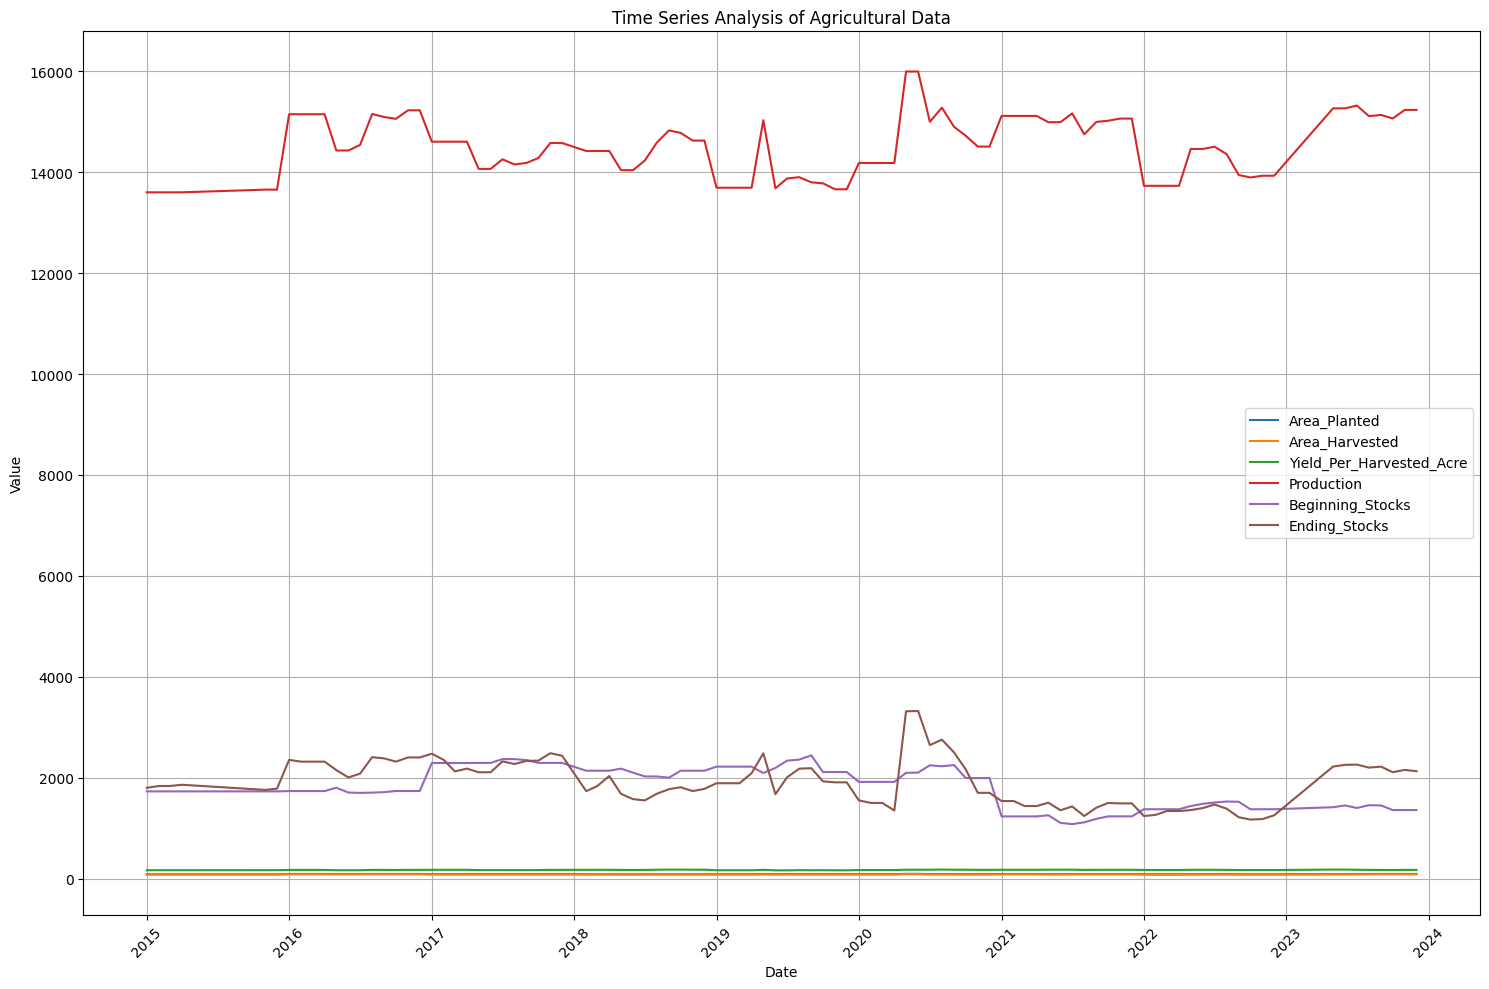

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

# Selecting key variables for time series analysis
variables_to_plot = ['Area_Planted', 'Area_Harvested', 'Yield_Per_Harvested_Acre', 'Production', 'Beginning_Stocks', 'Ending_Stocks']

# Plotting time series for selected variables again, now that we know 'projected_dates' is already in datetime format
plt.figure(figsize=(15, 10))
for variable in variables_to_plot:
    sns.lineplot(data=df_cleaned, x='projected_dates', y=variable, label=variable)

plt.title('Time Series Analysis of Agricultural Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



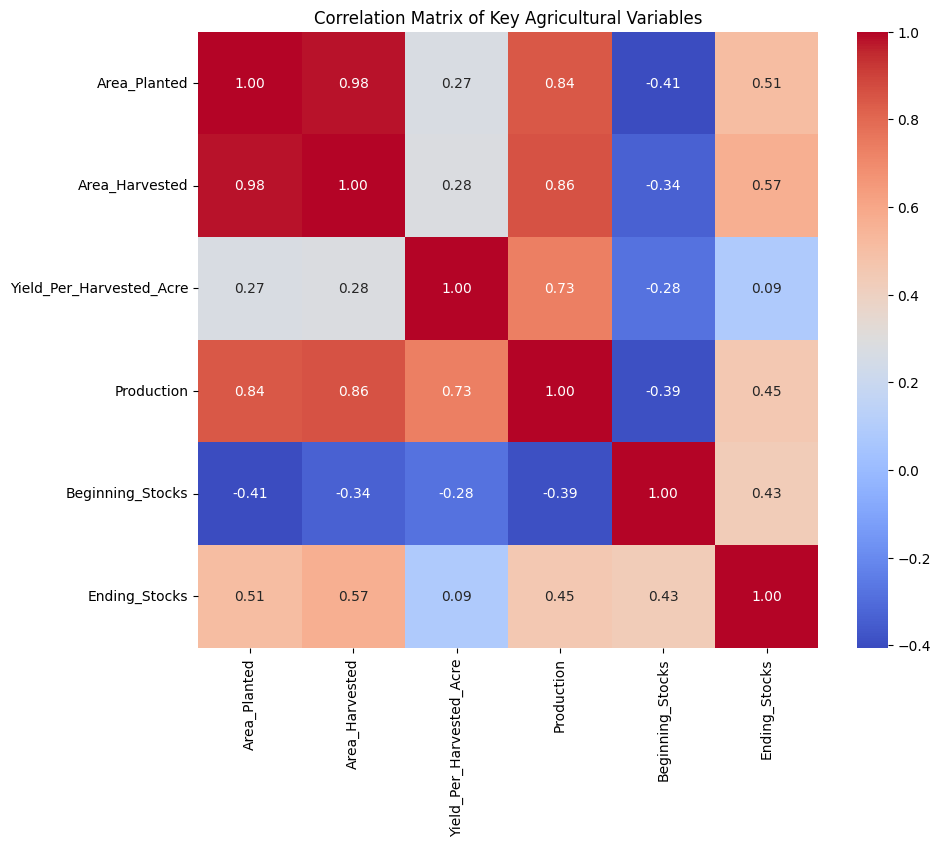

In [94]:
# Correlation analysis
correlation_matrix = df_cleaned[variables_to_plot].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Key Agricultural Variables')
plt.show()


<Figure size 1500x800 with 0 Axes>

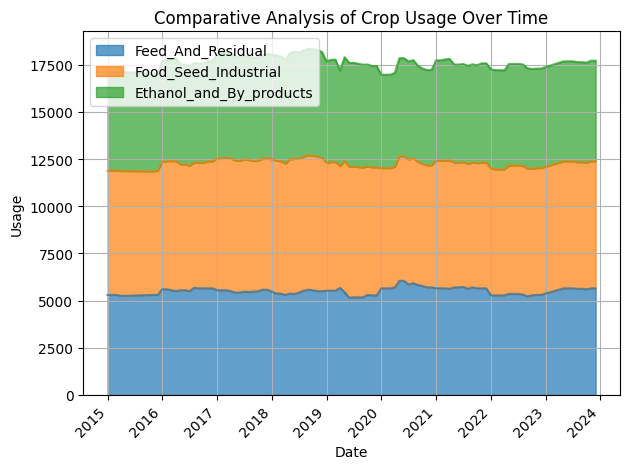

In [95]:
# Selecting usage variables for comparative analysis
usage_variables = ['Feed_And_Residual', 'Food_Seed_Industrial', 'Ethanol_and_By_products']

# Preparing the data for stacked area chart
usage_data = df_cleaned[['projected_dates'] + usage_variables].set_index('projected_dates')

# Plotting stacked area chart
plt.figure(figsize=(15, 8))
usage_data.plot(kind='area', stacked=True, alpha=0.7)
plt.title('Comparative Analysis of Crop Usage Over Time')
plt.ylabel('Usage')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


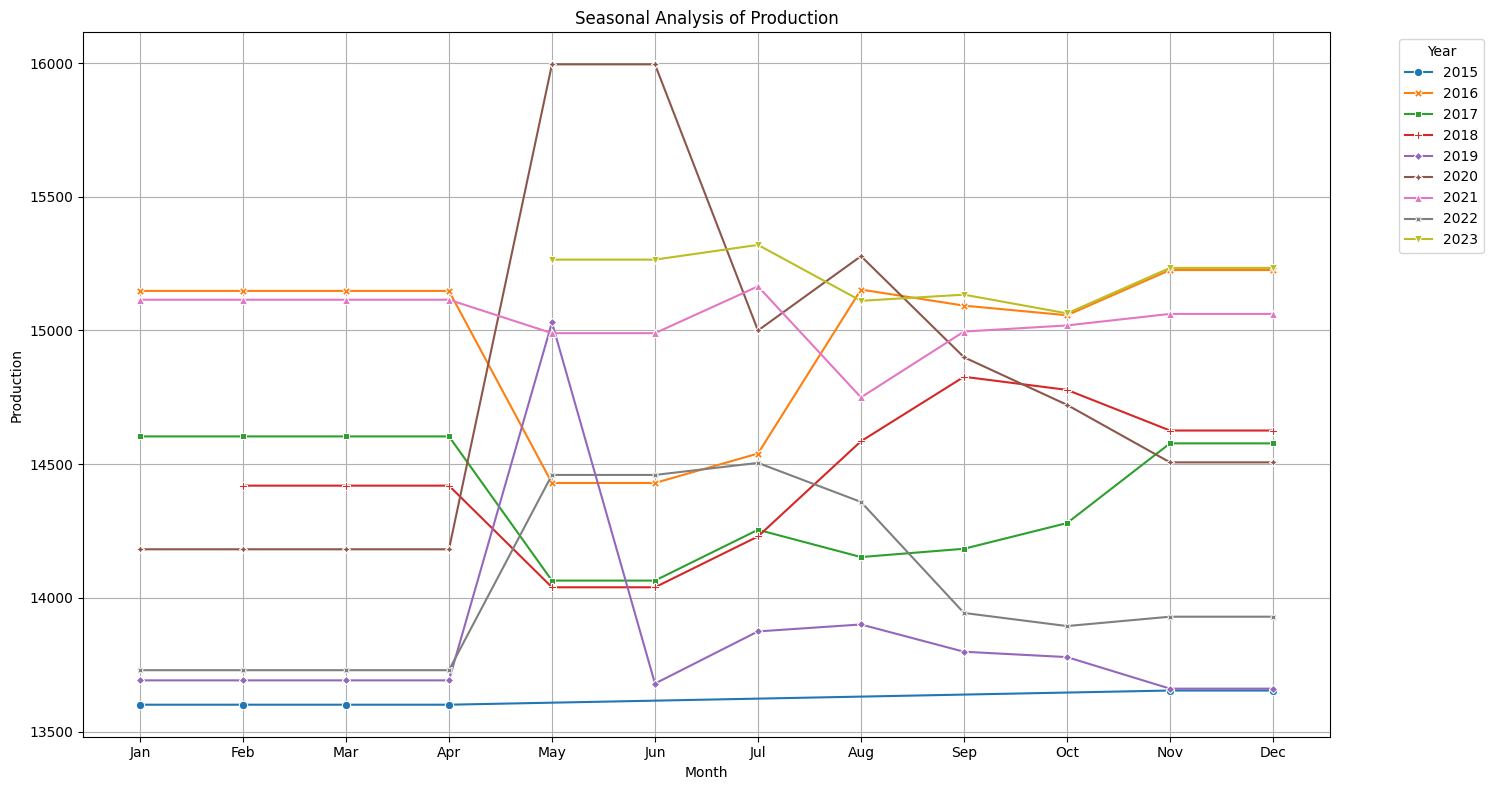

In [97]:
import matplotlib.dates as mdates

# Extracting month and year for seasonal analysis
df_cleaned['Year'] = df_cleaned['projected_dates'].dt.year
df_cleaned['Month'] = df_cleaned['projected_dates'].dt.month

# Selecting a variable for seasonal analysis - let's choose 'Production'
seasonal_variable = 'Production'

# Let's create a pivot table for a clearer month-wise comparison across years
pivot_seasonal = df_cleaned.pivot_table(index='Month', columns='Year', values=seasonal_variable)

# Plotting the revised seasonal trends
plt.figure(figsize=(15, 8))
sns.lineplot(data=pivot_seasonal, markers=True, dashes=False)
plt.title('Seasonal Analysis of Production')
plt.xlabel('Month')
plt.ylabel(seasonal_variable)
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

### Build simple arima models